In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from deepant import ForecastBasedDataset, DataModule, DeepAnT, ForecastBasedAD
from pytorch_lightning.callbacks import ModelCheckpoint

import pytorch_lightning as pl
import seaborn as sns

from utils import ts_stats, create_sequences
pl.seed_everything(42, workers=True)


df = pd.read_csv('../data/Non_Disturbed_Resample_m.csv', parse_dates=['date'])
ts_stats(df)

## Interpolación
df['ndvi'] = df.ndvi.interpolate()
df.isnull().mean()

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42


Número de TSs: 100
Largo Promedio por TS: 268.0
Promedio de Nulos por TS: 12.23


date         0.0
ndvi         0.0
ts_id        0.0
ndvi_null    0.0
id           0.0
dtype: float64

In [2]:
ids = df.ts_id.unique()
sequences = []
divisor = []
indices = []
dates = []
seq_len = 10
for id in ids:
    ts = df.query('ts_id == @id').to_numpy()
    subsequences = np.zeros((len(ts)-seq_len+1, seq_len))
    subindices = np.empty((len(ts)-seq_len+1, seq_len), dtype = 'object')
    subdates = np.empty((len(ts)-seq_len+1, seq_len), dtype = 'datetime64[D]')
    subdivisor = np.zeros(len(ts))
    for i in range(len(ts)-seq_len+1):
        subsequences[i] = ts[i:i+seq_len,1]
        subindices[i] = ts[i:i+seq_len,4]
        subdates[i] = ts[i:i+seq_len,0]
        subdivisor[i:i+seq_len] += np.ones(seq_len)

    sequences.extend(subsequences)
    divisor.append(subdivisor)
    indices.extend(subindices)
    dates.extend(subdates)


In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
class ReconstructionBasedDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self): 
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype = torch.float)

In [5]:
data = ReconstructionBasedDataset(sequences)
data[0].shape

torch.Size([10])

In [6]:
class DataModule(pl.LightningDataModule):
    def __init__(self, sequences):
        super().__init__()
        self.sequences = sequences

    def setup(self, stage = None): 
        self.train_dataset = ReconstructionBasedDataset(self.sequences)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = 32, num_workers = 8, pin_memory = True, shuffle=False)
    
    def predict_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=1, num_workers = 8, pin_memory = True, shuffle=False)






In [7]:
class VanillaAE(nn.Module): 
    def __init__(self, input_dim, hs_1 = 40, hs_2 = 20, hs_3 = 10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hs_1)
        self.relu1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(hs_1, hs_2)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(hs_2, hs_3)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc4 = nn.Linear(hs_3, hs_2)
        self.relu4 = nn.ReLU(inplace=True)
        self.fc5 = nn.Linear(hs_2, hs_1)
        self.relu5 = nn.ReLU(inplace=True)
        self.fc6 = nn.Linear(hs_1, input_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        x = self.relu5(x)
        x = self.fc6(x)
        return x

vanilla_ae = VanillaAE(input_dim = seq_len)


class ReconstructionBasedAD(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x_hat = self.model(batch)
        loss = self.criterion(x_hat, batch)
        self.log('train_loss', loss,  prog_bar = True, logger = True)
        return loss

    def predict_step(self, batch, batch_idx):
        pred_seq = self(batch)
        loss = self.criterion(pred_seq, batch)
        return (pred_seq - batch)**2 
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-5)

    




In [8]:
NAME = 'VanillaAE_Non_Disturbed_Resample_m'
model = VanillaAE(input_dim = seq_len)
anomaly_detector = ReconstructionBasedAD(model)
dm = DataModule(sequences)
mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'train_loss', 
    mode = 'min'
    )

mc.CHECKPOINT_NAME_LAST = f'{NAME}-best-checkpoint'


trainer = pl.Trainer(max_epochs=30,
                    accelerator="gpu",
                    devices=1, 
                    callbacks=[mc], 
                    #progress_bar_refresh_rate=30, 
                    #fast_dev_run=True,
                    #overfit_batches=1
                    )
trainer.fit(anomaly_detector, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | model     | VanillaAE | 2.9 K 
1 | criterion | MSELoss   | 0     
----------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Epoch 0:   5%|▍         | 39/810 [00:00<00:15, 49.90it/s, loss=0.437, v_num=4, train_loss=0.491]

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/core/module.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=self.device)


Epoch 0: 100%|██████████| 810/810 [00:05<00:00, 156.55it/s, loss=0.324, v_num=4, train_loss=0.249] 

Epoch 0, global step 810: 'train_loss' reached 0.24924 (best 0.24924), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=0-step=810.ckpt' as top 1


Epoch 1: 100%|██████████| 810/810 [00:04<00:00, 185.14it/s, loss=0.265, v_num=4, train_loss=0.198] 

Epoch 1, global step 1620: 'train_loss' reached 0.19765 (best 0.19765), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=1-step=1620.ckpt' as top 1


Epoch 2: 100%|██████████| 810/810 [00:04<00:00, 187.63it/s, loss=0.194, v_num=4, train_loss=0.137] 

Epoch 2, global step 2430: 'train_loss' reached 0.13655 (best 0.13655), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=2-step=2430.ckpt' as top 1


Epoch 3: 100%|██████████| 810/810 [00:04<00:00, 186.09it/s, loss=0.11, v_num=4, train_loss=0.0688]  

Epoch 3, global step 3240: 'train_loss' reached 0.06885 (best 0.06885), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=3-step=3240.ckpt' as top 1


Epoch 4: 100%|██████████| 810/810 [00:04<00:00, 180.42it/s, loss=0.0445, v_num=4, train_loss=0.0216]

Epoch 4, global step 4050: 'train_loss' reached 0.02159 (best 0.02159), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=4-step=4050.ckpt' as top 1


Epoch 5: 100%|██████████| 810/810 [00:04<00:00, 184.90it/s, loss=0.018, v_num=4, train_loss=0.00697] 

Epoch 5, global step 4860: 'train_loss' reached 0.00697 (best 0.00697), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=5-step=4860.ckpt' as top 1


Epoch 6: 100%|██████████| 810/810 [00:04<00:00, 185.31it/s, loss=0.011, v_num=4, train_loss=0.00417]  

Epoch 6, global step 5670: 'train_loss' reached 0.00417 (best 0.00417), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=6-step=5670.ckpt' as top 1


Epoch 7: 100%|██████████| 810/810 [00:04<00:00, 185.84it/s, loss=0.00936, v_num=4, train_loss=0.00382]

Epoch 7, global step 6480: 'train_loss' reached 0.00382 (best 0.00382), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=7-step=6480.ckpt' as top 1


Epoch 8: 100%|██████████| 810/810 [00:04<00:00, 192.47it/s, loss=0.00901, v_num=4, train_loss=0.00391]

Epoch 8, global step 7290: 'train_loss' was not in top 1


Epoch 9: 100%|██████████| 810/810 [00:04<00:00, 195.07it/s, loss=0.00891, v_num=4, train_loss=0.00396]

Epoch 9, global step 8100: 'train_loss' was not in top 1


Epoch 10: 100%|██████████| 810/810 [00:04<00:00, 191.39it/s, loss=0.00884, v_num=4, train_loss=0.00399]

Epoch 10, global step 8910: 'train_loss' was not in top 1


Epoch 11: 100%|██████████| 810/810 [00:04<00:00, 195.91it/s, loss=0.00879, v_num=4, train_loss=0.00398]

Epoch 11, global step 9720: 'train_loss' was not in top 1


Epoch 12: 100%|██████████| 810/810 [00:04<00:00, 194.57it/s, loss=0.00874, v_num=4, train_loss=0.00397]

Epoch 12, global step 10530: 'train_loss' was not in top 1


Epoch 13: 100%|██████████| 810/810 [00:04<00:00, 198.77it/s, loss=0.00868, v_num=4, train_loss=0.00396]

Epoch 13, global step 11340: 'train_loss' was not in top 1


Epoch 14: 100%|██████████| 810/810 [00:04<00:00, 199.66it/s, loss=0.00862, v_num=4, train_loss=0.00395]

Epoch 14, global step 12150: 'train_loss' was not in top 1


Epoch 15: 100%|██████████| 810/810 [00:04<00:00, 201.70it/s, loss=0.00857, v_num=4, train_loss=0.00393]

Epoch 15, global step 12960: 'train_loss' was not in top 1


Epoch 16: 100%|██████████| 810/810 [00:04<00:00, 201.24it/s, loss=0.00852, v_num=4, train_loss=0.00392]

Epoch 16, global step 13770: 'train_loss' was not in top 1


Epoch 17: 100%|██████████| 810/810 [00:04<00:00, 199.78it/s, loss=0.00847, v_num=4, train_loss=0.00391]

Epoch 17, global step 14580: 'train_loss' was not in top 1


Epoch 18: 100%|██████████| 810/810 [00:04<00:00, 200.41it/s, loss=0.00843, v_num=4, train_loss=0.00389]

Epoch 18, global step 15390: 'train_loss' was not in top 1


Epoch 19: 100%|██████████| 810/810 [00:04<00:00, 200.42it/s, loss=0.00838, v_num=4, train_loss=0.00388]

Epoch 19, global step 16200: 'train_loss' was not in top 1


Epoch 20: 100%|██████████| 810/810 [00:04<00:00, 198.34it/s, loss=0.00834, v_num=4, train_loss=0.00386]

Epoch 20, global step 17010: 'train_loss' was not in top 1


Epoch 21: 100%|██████████| 810/810 [00:04<00:00, 199.22it/s, loss=0.00829, v_num=4, train_loss=0.00385]

Epoch 21, global step 17820: 'train_loss' was not in top 1


Epoch 22: 100%|██████████| 810/810 [00:04<00:00, 201.15it/s, loss=0.00825, v_num=4, train_loss=0.00384]

Epoch 22, global step 18630: 'train_loss' was not in top 1


Epoch 23: 100%|██████████| 810/810 [00:04<00:00, 197.75it/s, loss=0.00821, v_num=4, train_loss=0.00382]

Epoch 23, global step 19440: 'train_loss' reached 0.00382 (best 0.00382), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=23-step=19440.ckpt' as top 1


Epoch 24: 100%|██████████| 810/810 [00:04<00:00, 197.39it/s, loss=0.00817, v_num=4, train_loss=0.00381]

Epoch 24, global step 20250: 'train_loss' reached 0.00381 (best 0.00381), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=24-step=20250.ckpt' as top 1


Epoch 25: 100%|██████████| 810/810 [00:04<00:00, 199.10it/s, loss=0.00813, v_num=4, train_loss=0.00379]

Epoch 25, global step 21060: 'train_loss' reached 0.00379 (best 0.00379), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=25-step=21060.ckpt' as top 1


Epoch 26: 100%|██████████| 810/810 [00:04<00:00, 199.22it/s, loss=0.00808, v_num=4, train_loss=0.00378]

Epoch 26, global step 21870: 'train_loss' reached 0.00378 (best 0.00378), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=26-step=21870.ckpt' as top 1


Epoch 27: 100%|██████████| 810/810 [00:04<00:00, 199.48it/s, loss=0.00804, v_num=4, train_loss=0.00376]

Epoch 27, global step 22680: 'train_loss' reached 0.00376 (best 0.00376), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=27-step=22680.ckpt' as top 1


Epoch 28: 100%|██████████| 810/810 [00:04<00:00, 187.36it/s, loss=0.008, v_num=4, train_loss=0.00374]  

Epoch 28, global step 23490: 'train_loss' reached 0.00374 (best 0.00374), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=28-step=23490.ckpt' as top 1


Epoch 29: 100%|██████████| 810/810 [00:04<00:00, 185.24it/s, loss=0.00796, v_num=4, train_loss=0.00373]

Epoch 29, global step 24300: 'train_loss' reached 0.00373 (best 0.00373), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=29-step=24300-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 810/810 [00:04<00:00, 184.81it/s, loss=0.00796, v_num=4, train_loss=0.00373]


In [9]:
errors = trainer.predict(anomaly_detector, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 25900/25900 [00:45<00:00, 566.99it/s]


In [12]:
errors[0], indices[0]

(tensor([[0.0129, 0.0135, 0.0085, 0.0079, 0.4586, 0.0016, 0.0021, 0.0033, 0.0015,
          0.0132]]),
 array(['0000-1', '0000-2', '0000-3', '0000-4', '0000-5', '0000-6',
        '0000-7', '0000-8', '0000-9', '0000-10'], dtype=object))

In [18]:
len(errors)

25900

In [132]:
suma = np.zeros(len(data))
for i in range(100):
    for j in range(i*259, i*259+259):
        suma[j:j+seq_len] += errors[j].T.squeeze(-1).cpu().numpy()


ValueError: operands could not be broadcast together with shapes (9,) (10,) (9,) 

In [149]:
divisor[0].shape

(268,)

In [148]:
np.repeat(divisor[0], 259).shape

(69412,)

In [140]:
np.array(divisor*259).shape

(25900, 268)

In [157]:
divisor = np.array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 10., 10., 10.,
       10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,  9.,
        8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.])

divisor_final = np.repeat(divisor, 100)


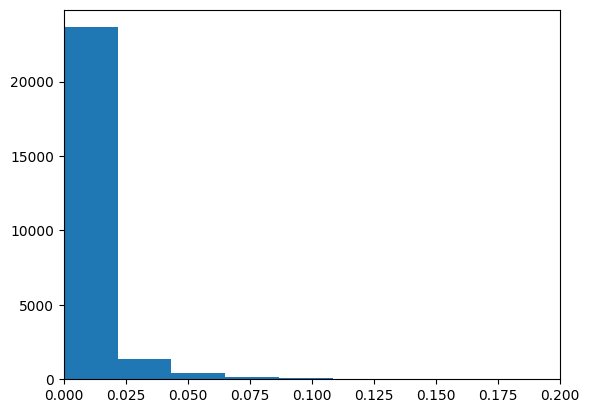

In [165]:
plt.hist(suma/divisor_final, bins = 100)
plt.xlim(0, 0.2);

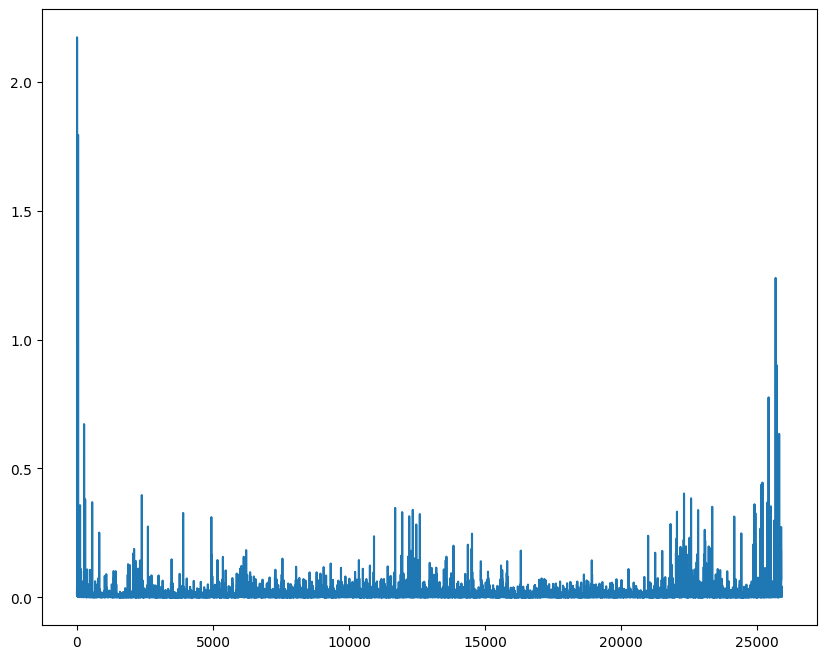

In [161]:
plt.figure(figsize = (10, 8))
plt.plot(suma/divisor_final);